# **GAN'S Anime Face Generation**

## 1) Introduction

**Generative Adversarial Networks (GANs)**   are a powerful framework for training generative models, meaning models that can generate new, realistic data samples. The basic idea behind GANs is to have two neural networks, a generator, and a discriminator, that are trained simultaneously through adversarial training.

Generative models aim to learn the underlying distribution of a dataset to generate new samples that resemble the training data. GANs fall under the category of generative models, along with other approaches like Variational Autoencoders (VAEs).

**Generator Network:**
The generator is a neural network that takes random noise as input and generates synthetic data samples. The goal of the generator is to produce data that is indistinguishable from real data.

**Discriminator Network:**

The discriminator is another neural network that takes input data (either real or generated) and predicts whether it is real or fake. The goal of the discriminator is to correctly classify real and generated data.

**Adversarial Training:**

The generator and discriminator are trained simultaneously through a competitive process. The generator aims to improve its ability to generate realistic data to fool the discriminator. The discriminator aims to improve its ability to distinguish between real and generated data.

**Objective Function:**

The training process involves minimizing a specific objective function, often referred to as the adversarial loss or minimax loss. The generator and discriminator are involved in a game where the generator tries to minimize the discriminator's ability to distinguish between real and fake data. Training Steps:

During each training step, the generator generates fake data, and the discriminator classifies both real and fake data. The gradients from the discriminator's predictions are backpropagated to update the weights of the discriminator. Simultaneously, the gradients from the generator's output are backpropagated to update the weights of the generator. This process is repeated iteratively until the generator produces realistic data. Convergence:

Ideally, the generator and discriminator reach a point where the generator generates data that is indistinguishable from real data, and the discriminator cannot reliably classify between real and fake data.

Researchers have proposed various GAN variants and improvements to address challenges and enhance performance. Some examples include DCGAN (Deep Convolutional GAN), WGAN (Wasserstein GAN), and conditional GANs.


![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQgM9UHxSUdXI8VjC8FePagaBD_czX99mQEZxl58CgLZA&s])

## **Importing Necessary Libraries**

In [ ]:
import pathlib  
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, LeakyReLU
from tensorflow.keras.layers import Conv2D, MaxPool2D, AvgPool2D, Dropout, Reshape, Conv2DTranspose,UpSampling2D
from tensorflow.keras.models import Sequential
from keras.metrics import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [2]:
root_path="/kaggle/input/animefacedataset/images"
root_path=pathlib.Path(root_path)
print(root_path)

/kaggle/input/animefacedataset/images


## **Prepare The Data And View Samples**

In [3]:
batch_size=32
img_height=64
img_width=64

In [4]:
data=tf.keras.preprocessing.image_dataset_from_directory(
seed=12,
batch_size=32,
image_size=(img_height, img_width),
shuffle=True,    
directory=root_path,
     label_mode=None,
)

Found 63565 files.


In [5]:
data

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

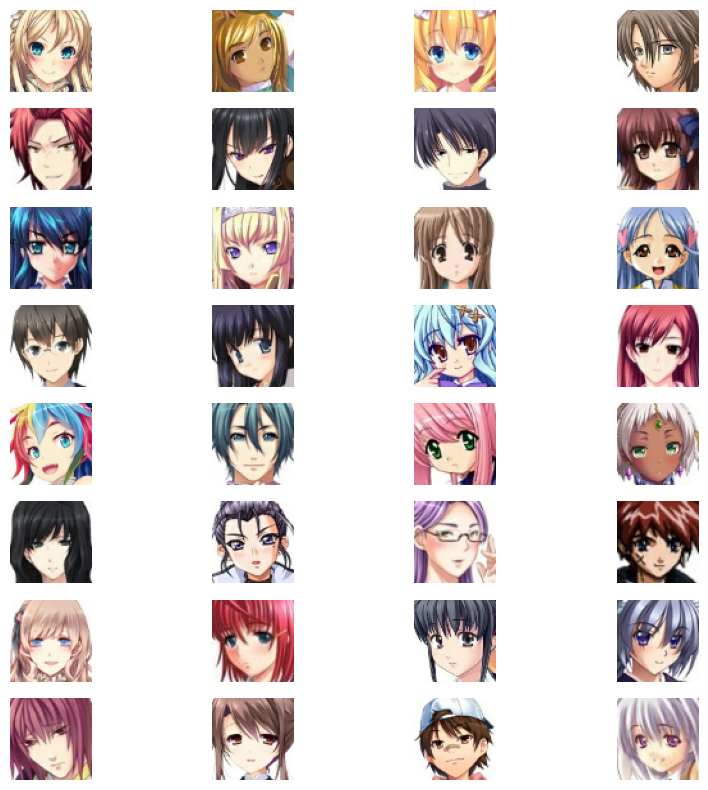

In [6]:
images_batch = next(iter(data.take(1)))
images_np = images_batch.numpy().astype("uint32")
plt.figure(figsize=(10, 10))
for i in range(32):
    plt.subplot(8, 4, i + 1)  # 4 rows, 8 columns, ith image
    plt.imshow(images_np[i])
    plt.axis("off")  # Turn off axis
plt.show()

In [7]:
data = data.map(lambda d : ((d-127.5)/127.5))
data

<_MapDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

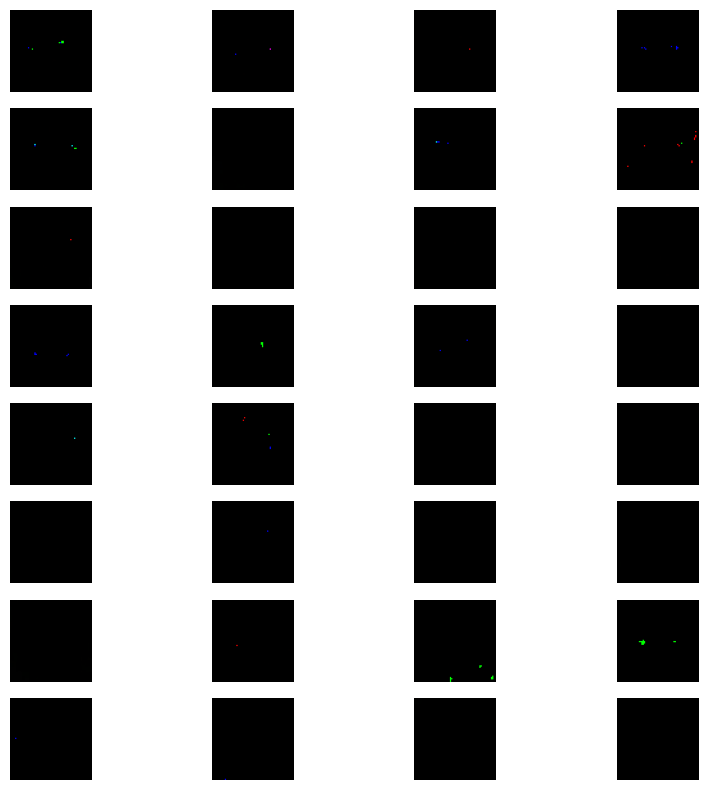

In [8]:
images_batch = next(iter(data.take(1)))
images_np = images_batch.numpy().astype("uint32")
plt.figure(figsize=(10, 10))
for i in range(32):
    plt.subplot(8, 4, i + 1)  # 4 rows, 8 columns, ith image
    plt.imshow(images_np[i])
    plt.axis("off")  # Turn off axis
plt.show()

## 4) **Build Discriminator**

In [9]:
def Discriminator():
    discriminator = Sequential()
    
    discriminator.add(Conv2D(64, kernel_size=4, strides=2, padding="same", input_shape=(64,64,3)))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(BatchNormalization())
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Conv2D(128, kernel_size=4, strides=2, padding="same"))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(BatchNormalization())
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Conv2D(256, kernel_size=4, strides=2, padding="same"))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(BatchNormalization())
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Flatten())
    discriminator.add(Dropout(0.2))
    discriminator.add(Dense(1, activation="sigmoid"))
    return discriminator

D_model = Discriminator()
D_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        16,385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 677,057 (2.58 MB)

 Trainable params: 676,161 (2.58 MB)

 Non-trainable params: 896 (3.50 KB)

## **Build Generator**

In [10]:
latent_dim = 100

In [11]:
def Generator(latent_dim):
    generator = Sequential()
    generator.add(Dense(256 * 4 * 4, input_dim=latent_dim))
    generator.add(Reshape((4, 4, 256)))
    generator.add(BatchNormalization())
    
    generator.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(BatchNormalization())
    
    generator.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(BatchNormalization())
    
    generator.add(Conv2DTranspose(32, kernel_size=4, strides=2, padding="same"))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(BatchNormalization())
    
    generator.add(Conv2DTranspose(3, kernel_size=4, strides=2, padding="same", activation="tanh"))
    return generator


In [12]:
G_model = Generator(latent_dim)
G_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 4096)           │       413,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        32,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 3)      │         1,539 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,105,507 (4.22 MB)

 Trainable params: 1,104,547 (4.21 MB)

 Non-trainable params: 960 (3.75 KB)

## **Testing Our Models**

In [13]:
random_noise = tf.random.normal([1,latent_dim])
random_noise.shape

TensorShape([1, 100])

In [14]:
G_output_on_random_noise = G_model(random_noise, training=False)

In [15]:
G_output_on_random_noise.shape

TensorShape([1, 64, 64, 3])

(-0.5, 63.5, 63.5, -0.5)

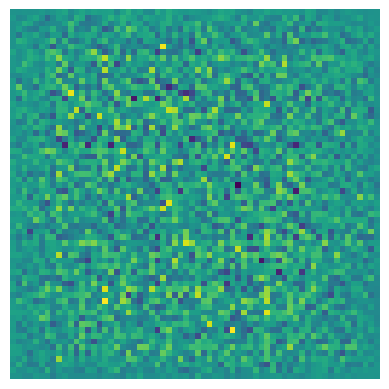

In [16]:
plt.imshow(G_output_on_random_noise[0, :, :, 0])
plt.axis("off")


In [18]:
D_output_on_random_noise = D_model(G_output_on_random_noise)
print(D_output_on_random_noise)


tf.Tensor([[0.50022084]], shape=(1, 1), dtype=float32)


In [19]:
from tensorflow.keras.models import Model

## **Define the GAN Model**

In [20]:
# I take the code from tensorflow 
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))
        # Decode them to fake images
        generated_images = self.generator(seed)
        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        # Assemble labels discriminating real from fake images
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Sample random points in the latent space
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(seed))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [21]:
loss_fn = tf.keras.losses.BinaryCrossentropy()
model = GAN(discriminator=D_model, generator=G_model, latent_dim=latent_dim)


## **Compiling And Training the model**

In [22]:
D_optm = Adam(1e-4)
G_optm = Adam(1e-4)

In [23]:
model.compile(d_optimizer=D_optm, g_optimizer=G_optm, loss_fn=loss_fn)

In [35]:
hist=model.fit(data,epochs=200)


Epoch 1/200
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - d_loss: 0.0576 - g_loss: 7.1711
Epoch 2/200
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - d_loss: 0.0597 - g_loss: 7.2643
Epoch 3/200
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - d_loss: 0.0590 - g_loss: 7.3364
Epoch 4/200
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - d_loss: 0.0637 - g_loss: 7.2677
Epoch 5/200
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - d_loss: 0.0584 - g_loss: 7.4282
Epoch 6/200
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - d_loss: 0.0546 - g_loss: 7.4914
Epoch 7/200
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 46s 23ms/step - d_loss: 0.0517 - g_loss: 7.6903
Epoch 8/200
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 46s 23ms/step - d_loss: 0.0535 - g_loss: 7.7965
Epoch 9/200
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - d_loss: 0.0493 - g_loss: 7.9102
Epoch 10/200
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 49s 24ms/step - d_loss: 0.0480 - g_loss: 8.2138
Epoch 11/200
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 50s 25ms/step - d_loss: 0.0534 - g_loss: 8.28

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1987/1987 ━━━━━━━━━━━━━━━━━━━━ 57s 29ms/step - d_loss: -3.8631 - g_loss: 1588.3250
Epoch 157/200
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 43s 22ms/step - d_loss: 18.7598 - g_loss: 3097.5811
Epoch 158/200
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - d_loss: -4.9032 - g_loss: 2334.1836
Epoch 188/200
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 42s 21ms/step - d_loss: -9.4186 - g_loss: 2757.0188
Epoch 189/200
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 47s 23ms/step - d_loss: -5.9015 - g_loss: 2416.8657
Epoch 190/200
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - d_loss: -8.0202 - g_loss: 2736.8345
Epoch 191/200
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - d_loss: -5.2534 - g_loss: 2411.9646
Epoch 192/200
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - d_loss: -7.3557 - g_loss: 2700.5349
Epoch 193/200
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - d_loss: -4.3902 - g_loss: 2361.9995
Epoch 194/200
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - d_loss: -3.9565 - g_loss: 2193.8433
Epoch 195/200
1987/1987 ━━━━━━━━━━━━━━━━━━━━

## **Generating New Images**

In [41]:
noise = tf.random.normal([32, 100])
noise.shape

TensorShape([32, 100])

In [42]:
noise[0]

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([-0.43743464, -1.7679908 , -0.22585149, -1.8494898 , -2.2157168 ,
        0.3535708 ,  0.44346657, -0.05817779, -0.8012351 ,  0.7073068 ,
       -0.33078954,  0.15159549, -0.07333065,  1.3962129 , -2.255777  ,
       -0.3791033 ,  0.9638377 ,  0.49235302, -0.8487147 ,  0.15840904,
       -1.2520229 ,  0.9934917 ,  0.31711015, -0.33791462,  2.2885911 ,
        2.1002386 , -0.50319827, -1.0791612 , -0.73897636,  0.40914327,
       -1.7429005 , -1.5856943 ,  1.7577981 , -0.46221808,  1.8832326 ,
        1.2665769 , -0.21629097,  1.8337649 ,  0.9031538 , -0.6653786 ,
       -0.79521316,  0.4539472 ,  0.05399762, -0.5114058 ,  0.58003247,
        1.1721593 ,  0.1536548 , -1.0764135 ,  0.71903175, -0.65066004,
        0.28975257, -1.993321  ,  0.17576027,  0.01243367, -0.4358615 ,
       -0.49048677,  0.8812387 , -0.49434116, -0.69644916,  1.2338557 ,
        0.05997376,  0.7042135 , -2.3419704 , -0.3207506 , -0.3661304 ,
        0.063680

In [43]:
generated_images = G_model(noise, training=False)

In [44]:
generated_images1 = (generated_images+127.5)*127.5

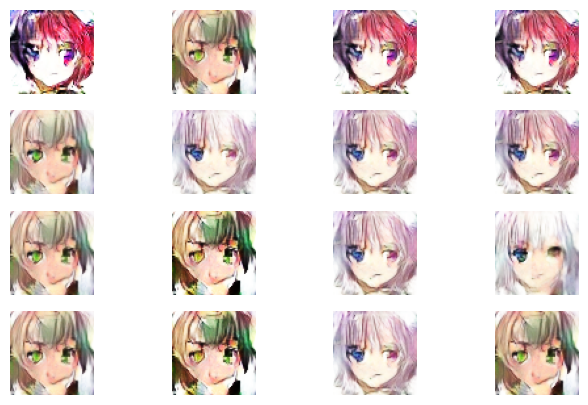

In [45]:
plt.figure(figsize=(8, 5))
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(generated_images1[i].numpy().astype("uint8"))
    plt.axis('off')

plt.show()

## **Saving the model**

In [46]:
G_model.save('my_model.h5')


In [47]:
loaded_model = tf.keras.models.load_model('my_model.h5')

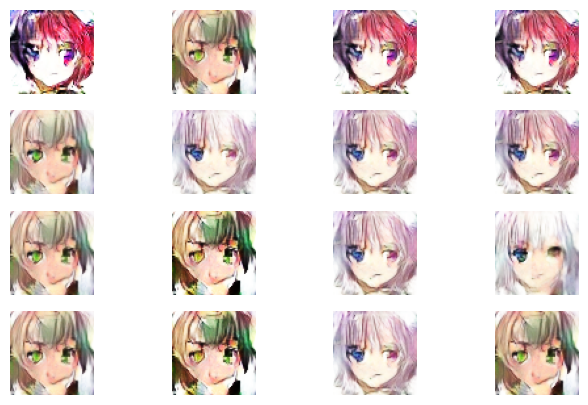

In [48]:
noise = tf.random.normal([32, 100])
generated_images = loaded_model(noise, training=False)
plt.figure(figsize=(8, 5))
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(generated_images1[i].numpy().astype("uint8"))
    plt.axis('off')

plt.show()